[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_06/Taller/MISIS4825_Laboratorio06_Taller.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 06 - Taller: Fundamentos de Machine Learning y Redes Neuronales

## Introducción

En este taller exploraremos el uso de TensorFlow y Keras para el diseño y entrenamiento de redes neuronales perceptrón multicapa. Utilizaremos el conjunto de datos **Alien vs. Predator** para construir un modelo capaz de clasificar imágenes de acuerdo a su clase.

## Contenido del Taller

1. **Preprocesamiento de Datos**  
   - Implemente técnicas de preprocesamiento como normalización, estandarización y aumentación de datos utilizando TensorFlow y Keras.  
   - Adicionalmente, puede aplicar cualquier procesamiento explicado previamente en el curso.  
   - Justifique cada técnica de preprocesamiento seleccionada y analice su impacto en el desempeño del modelo.

2. **Construcción de un Modelo de Red Neuronal Perceptrón Multicapa**  
   - Desarrolle un modelo de red neuronal perceptrón multicapa utilizando Keras.  
   - Discuta la elección de la arquitectura, detallando el número de capas, la cantidad de neuronas por capa y las funciones de activación empleadas.

3. **Definición de Funciones de Callbacks para Monitorear el Entrenamiento**  
   - Implemente callbacks en TensorFlow y Keras para monitorear el proceso de entrenamiento.  
   - Explique cómo estos callbacks pueden ayudar a identificar problemas como el sobreajuste o un entrenamiento insuficiente.  
   - Justifique la selección y configuración de cada callback.

4. **Entrenamiento y Exploración de Resultados**  
   - Detalle el proceso de entrenamiento, incluyendo la elección de la tasa de aprendizaje, el optimizador y la función de pérdida.  
   - Analice los resultados obtenidos utilizando métricas de desempeño como precisión, recall y F1-score.  
   - Compare los resultados y discuta posibles mejoras en el modelo.

## Datos

[Alien vs. Predator images](https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images)

# **Taller 6**

### **Descarga y Preparación del dataset**

In [1]:
import json
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split

2025-04-07 16:14:10.257205: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 16:14:10.258231: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 16:14:10.261891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 16:14:10.270360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744060450.285810  164308 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744060450.29

In [2]:
with open('./kaggle.json') as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('pmigdal/alien-vs-predator-images', unzip=True)

redundant_folder_path = 'alien_vs_predator_thumbnails'
if os.path.exists(redundant_folder_path):
    shutil.rmtree(redundant_folder_path)

Dataset URL: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images


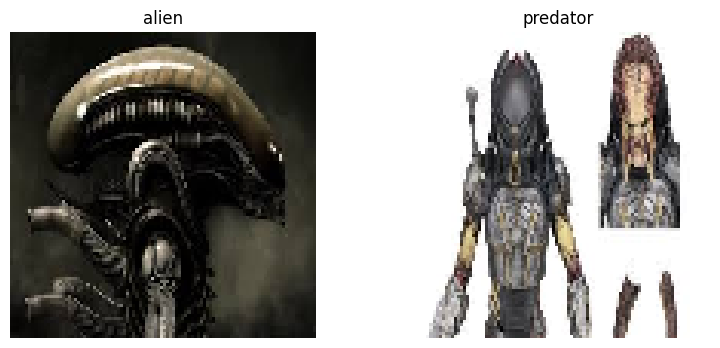

In [3]:
data_dir = 'data/train'
data_categories = os.listdir(data_dir)

plt.figure(figsize=(12, 10))
for i, category in enumerate(data_categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[13]
    img_path = os.path.join(folder, image_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(100, 100))
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array)
    plt.title(category)
    plt.axis('off')
plt.tight_layout()
plt.show()

### **Preparación de Datos y División en Entrenamiento, Validación y Test**

In [4]:
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir)
             for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]

data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=42)

print("Total de imágenes:", len(data_df))
print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Test:", len(test_df))

Total de imágenes: 694
Entrenamiento: 485
Validación: 140
Test: 69


#### **Procesamiento de Datos**  
   

##### Justificación

Parametros para ImageDataGenerator:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
)

test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
)

val_gen = test_val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
    shuffle=False,
)

test_gen = test_val_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(100, 100),
    batch_size=32,
    shuffle=False,
)

Found 485 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 69 validated image filenames belonging to 2 classes.


### **Construcción y Compilación del Modelo**

##### Justificación

Falta ajustar las capas

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

model = Sequential([
    Flatten(input_shape=(100, 100, 3)),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(len(data_categories), activation='softmax')
])

# Resumen del modelo y su arquitectura
model.summary()

# Compilar el modelo
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

/home/pukini/.pyenv/versions/3.12.9/envs/iv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
E0000 00:00:1744060455.915341  164308 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1744060455.918543  164308 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    15,360,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,492,354 (59.10 MB)

 Trainable params: 15,492,354 (59.10 MB)

 Non-trainable params: 0 (0.00 B)